In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans
import os

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import shap, lime

# suppress runtime warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [69]:
# config
BATCH_SIZE = 256
MODEL_DIR = 'models'
SAVE_FIGS = True     # whether to save figures folder
TRAIN_MODEL = False  # whether to train the model

# make models directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
model_save_path = os.path.join(MODEL_DIR, 'mlp_best_model.pth')

# seed
np.random.seed(2025)
SEED_BASE = 2025
SHAP_waterfall_ct = 3 # 3 random samples

# file to use
data_file = 'data/pok_2010_2025_augmented.csv'
if not os.path.exists(data_file):
    # if not exist, use toy dataset
    data_file = 'data/toy_pok_dataset.csv'

# make figures and shap directories
if SAVE_FIGS and not os.path.exists('figures'):
    os.makedirs('figures')
if SAVE_FIGS and not os.path.exists('figures/shap'):
    os.makedirs('figures/shap')
if SAVE_FIGS and not os.path.exists('figures/lime'):
    os.makedirs('figures/lime')
if SAVE_FIGS and not os.path.exists('figures/synergy'):
    os.makedirs('figures/synergy')

In [70]:
#data = pd.read_csv('data/pok_2010_2025_augmented.csv')
data = pd.read_csv(data_file)
data['date'] = pd.to_datetime(data['date'])

# make pok as ratio greater than 0.1
data['pok'] = (data['pok_ratio'] > 0.1).astype(int)
print(f"Class distribution:\n{data['pok'].value_counts(normalize=True)}")

val_splitday = pd.to_datetime('2022-12-31')
test_splitday = pd.to_datetime('2023-12-31')

# y-ratio vector associated with X_test
y_test_ratio = data[data['date'] > test_splitday]['pok_ratio'].reset_index(drop=True)

# prepare data
data = data.drop(columns=['species', 'gear', 'weight', 'pok_ratio'])

data_train = data[data['date'] <= val_splitday]
data_val = data[(data['date'] > val_splitday) & (data['date'] <= test_splitday)]
data_test = data[data['date'] > test_splitday]

X_train = data_train.drop(columns=['pok', 'date']).reset_index(drop=True)
y_train = data_train['pok'].reset_index(drop=True)
X_val = data_val.drop(columns=['pok', 'date']).reset_index(drop=True)
y_val = data_val['pok'].reset_index(drop=True)
X_test = data_test.drop(columns=['pok', 'date']).reset_index(drop=True)
y_test = data_test['pok'].reset_index(drop=True)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")
X_test.head()

Class distribution:
pok
0    0.78354
1    0.21646
Name: proportion, dtype: float64
Training samples: 1016881, Validation samples: 65776, Test samples: 108489


,latitude,longitude,depth,thetao,uo,vo,so,thetao_grad,chl,no3,nppv,o2,po4,si,day_cos,day_sin
0,64.9758,-24.0175,246.625200,5.228278,-0.043947,0.062258,35.019989,3.897163,0.069659,7.836014,0.017190,287.540741,0.580970,3.890184,0.999408,0.034398
1,64.9185,-24.0353,108.751520,5.502213,0.065310,0.211188,35.065769,6.025003,0.069659,7.836014,0.017190,287.540741,0.580970,3.890184,0.999408,0.034398
2,64.8673,-24.0747,64.917168,5.178473,-0.001831,0.319834,35.027618,4.765457,0.081872,6.923312,0.052279,292.967468,0.527286,3.415034,0.999408,0.034398
3,64.9198,-24.0180,80.465360,5.502213,0.065310,0.211188,35.065769,6.025003,0.069659,7.836014,0.017190,287.540741,0.580970,3.890184,0.999408,0.034398
4,63.5857,-20.4557,41.604976,6.356242,0.012207,0.001221,34.681232,3.200496,0.093789,5.887146,0.062200,286.737061,0.464209,3.390041,0.999408,0.034398


In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # only transform
X_test_scaled = scaler.transform(X_test) # only transform

# make tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# make dataset
trainset = TensorDataset(X_train_t, y_train_t)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# make val dataset
valset = TensorDataset(X_val_t, y_val_t)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
class PollockClassifier(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)
    

model = PollockClassifier(in_features=X_train_t.shape[1])
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [6]:
if TRAIN_MODEL:
    train_losses = []
    val_losses = []
    val_accuracies = []

    # early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    # training loop
    for epoch in range(50):
        model.train()
        total_loss = 0
        for xb, yb in trainloader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_function(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(trainloader.dataset)
        train_losses.append(avg_train_loss)

        # validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in valloader:
                val_preds = model(xb)
                loss = loss_function(val_preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_preds = (val_preds > 0.5).float()
                correct += (val_preds == yb).sum().item()
                total += yb.size(0)

        avg_val_loss = val_loss / len(valloader.dataset)
        val_losses.append(avg_val_loss)

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            # save the best model
            torch.save(model.state_dict(), model_save_path)
            print("Best model saved with val loss:", best_val_loss)

            # save metrics as csv
            metrics_df = pd.DataFrame({
                'epoch': list(range(1, epoch+2)),
                'train_loss': train_losses,
                'val_loss': val_losses,
                'val_accuracy': val_accuracies
            })
            metrics_df.to_csv(os.path.join(MODEL_DIR, 'mlp_training_metrics.csv'), index=False)
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered at epoch", epoch+1, "after", patience, "epochs without improvement.")
            break

if not TRAIN_MODEL:
    # load the best model
    model.load_state_dict(torch.load(model_save_path))
    # load training metrics
    metrics_df = pd.read_csv(os.path.join(MODEL_DIR, 'mlp_training_metrics.csv'))
    train_losses = metrics_df['train_loss'].tolist()
    val_losses = metrics_df['val_loss'].tolist()
    val_accuracies = metrics_df['val_accuracy'].tolist()

    print("Best model loaded from", model_save_path)


Best model loaded from models/mlp_best_model.pth


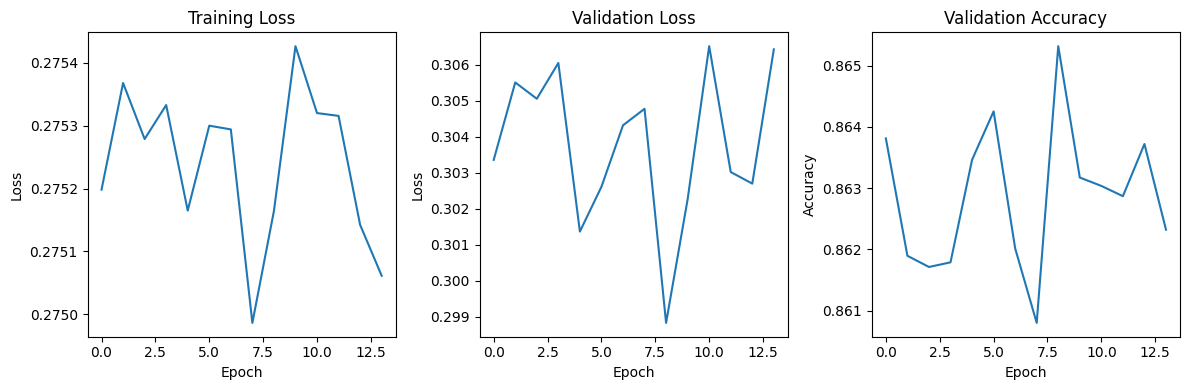

In [7]:
# plot training metrics
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,3,2)
plt.plot(val_losses)
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1,3,3)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/training_metrics.pdf')
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     85584
           1       0.67      0.62      0.64     22905

    accuracy                           0.85    108489
   macro avg       0.78      0.77      0.78    108489
weighted avg       0.85      0.85      0.85    108489

AUC-ROC: 0.90

Confusion Matrix:
[[78482  7102]
 [ 8678 14227]]


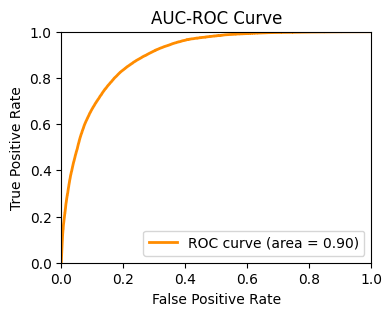

In [12]:
model.eval()

with torch.no_grad():
    preds = model(X_test_t).numpy()
    
y_pred = (preds > 0.5).astype(int)
print(classification_report(y_test, y_pred))

# AUC-ROC
auc = roc_auc_score(y_test, preds)
print(f"AUC-ROC: {auc:.2f}")

# print confusion matrix
conf = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n{conf}")

# plot AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
model.net

Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=1, bias=True)
  (7): Sigmoid()
)

In [14]:
def layer_neurons(model, X, layer_idx):
    acts = []
    def hook_fn(m, i, o): acts.append(o.detach().cpu())
    h = model.net[layer_idx].register_forward_hook(hook_fn)
    with torch.no_grad(): 
        _ = model(X)
    h.remove()

    A = acts[0].numpy()    # shape: [batch, neurons]
    n_neurons = A.shape[1]
    # assign each neuron to its own group
    groups = [[i] for i in range(n_neurons)]
    return groups, A

# probability-based synergy computation
def compute_synergy_neurons(model, X, layer_idx, neuron_groups):
    base_preds = model(X).detach().cpu().numpy()

    # probability difference after masking some neurons
    def prob_diff(groups_to_mask):
        def hook_fn(m, i, o):
            for g in groups_to_mask:
                o[:, g] = 0    # zero those neurons
            return o

        h = model.net[layer_idx].register_forward_hook(hook_fn)
        masked_preds = model(X).detach().cpu().numpy()
        h.remove()
        
        # mean absolute difference in predicted probabilities
        diff = np.mean(np.abs(base_preds - masked_preds))
        return diff

    # influence of each neuron alone
    delta_i = np.array([prob_diff([g]) for g in neuron_groups])
    
    n = len(neuron_groups)
    synergy = np.zeros((n, n))

    for i in range(n): # pairwise synergies
        for j in range(i+1, n):
            # delta_ij is the mae between masking both i and j
            delta_ij = prob_diff([neuron_groups[i], neuron_groups[j]])
            synergy[i, j] = delta_ij - (delta_i[i] + delta_i[j])

    return delta_i, synergy

# for layer 2
neuron_groups_2, A2 = layer_neurons(model, X_test_t, layer_idx=2)
delta2, synergy2 = compute_synergy_neurons(
    model, X_test_t, layer_idx=2, neuron_groups=neuron_groups_2)

# for layer 5
neuron_groups_5, A5 = layer_neurons(model, X_test_t, layer_idx=5)
delta5, synergy5 = compute_synergy_neurons(
    model, X_test_t, layer_idx=5, neuron_groups=neuron_groups_5)

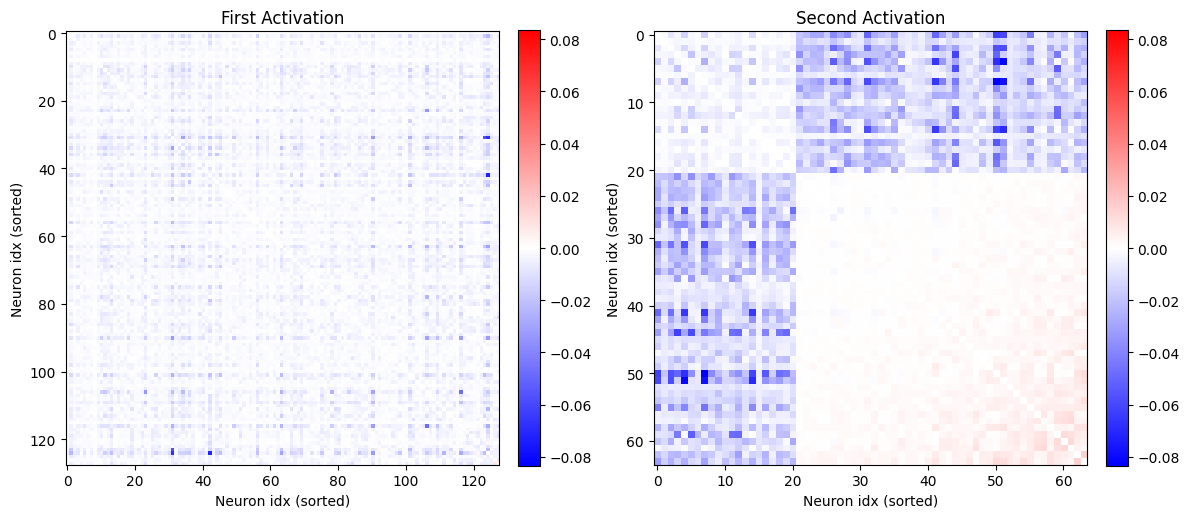

In [16]:
# plot both synergy matrices
s1 = max(abs(synergy2.min()), abs(synergy2.max()))
s2 = max(abs(synergy5.min()), abs(synergy5.max()))
s = max(s1, s2)


synergy2_full = synergy2 + synergy2.T
synergy5_full = synergy5 + synergy5.T
sorted_idx2 = np.argsort(np.sum(np.maximum(synergy2_full, 0), axis=1))
sorted_idx5 = np.argsort(np.sum(np.maximum(synergy5_full, 0), axis=1))
synergy2_sorted = synergy2_full[np.ix_(sorted_idx2, sorted_idx2)]
synergy5_sorted = synergy5_full[np.ix_(sorted_idx5, sorted_idx5)]

# set diagonal to nan
np.fill_diagonal(synergy2_sorted, np.nan)
np.fill_diagonal(synergy5_sorted, np.nan)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
c1 = ax1.imshow(synergy2_sorted, cmap='bwr', vmin=-s, vmax=s)
c2 = ax2.imshow(synergy5_sorted, cmap='bwr', vmin=-s, vmax=s)
ax1.set_title("First Activation")
ax2.set_title("Second Activation")
ax1.set_ylabel("Neuron idx (sorted)")
ax1.set_xlabel("Neuron idx (sorted)")
ax2.set_xlabel("Neuron idx (sorted)")
ax2.set_ylabel("Neuron idx (sorted)")
fig.colorbar(c1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(c2, ax=ax2, fraction=0.046, pad=0.04)
fig.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/synergy/synergy_matrices.pdf')
plt.show()


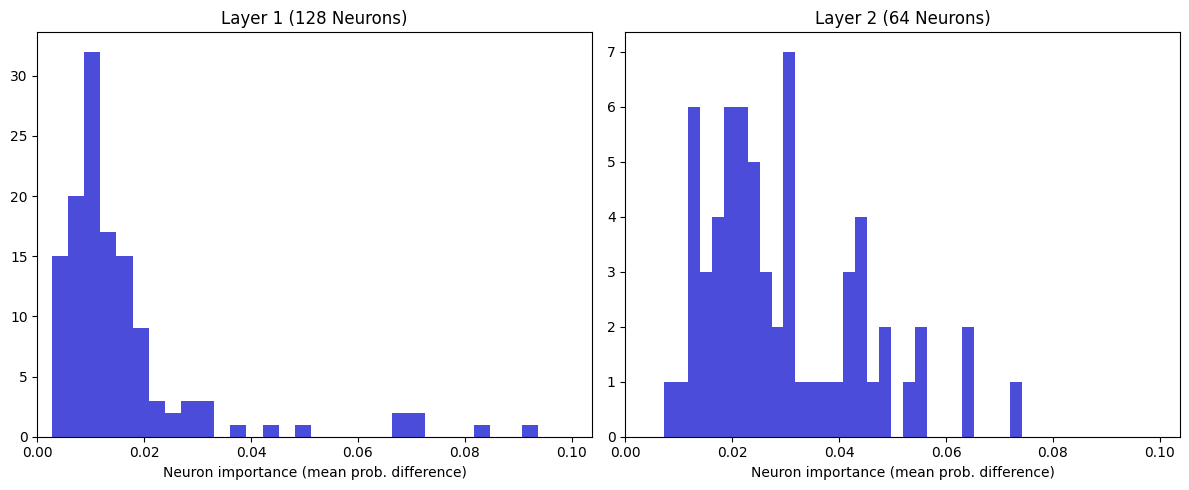

In [17]:
s = max(delta2.max(), delta5.max()) + 0.01
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(delta2, bins=30, alpha=0.7, color='mediumblue')
ax1.set_title("Layer 1 (128 Neurons)")
ax1.set_xlabel("Neuron importance (mean prob. difference)")
ax1.set_xlim(0,s)

ax2.hist(delta5, bins=30, alpha=0.7, color='mediumblue')
ax2.set_title("Layer 2 (64 Neurons)")
ax2.set_xlabel("Neuron importance (mean prob. difference)")
ax2.set_xlim(0,s)

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig('figures/synergy/neuron_importance_distribution.pdf')
plt.show()

# Pruning

In [18]:
def imp_pruning(layer_idx, prune_pct, method='tail'): 
    delta = delta5 if layer_idx == 5 else delta2
    neuron_groups = neuron_groups_5 if layer_idx == 5 else neuron_groups_2
    k = int(len(delta) * prune_pct)
    #sorted_indices = np.argsort(delta)
    if method == 'head': # remove most important
        sorted_indices = np.argsort(delta)[::-1]
    if method == 'tail': # remove least important
        sorted_indices = np.argsort(delta)
    neurons_to_prune = [neuron_groups[i] for i in sorted_indices[:k]]
    return neurons_to_prune

def recalibrate_bn(model, loader, device='cpu'):
    """Updates BN stats without changing weights."""
    model.train()  # Set to train mode to update running_mean/var
    with torch.no_grad(): # No gradients needed
        for xb, _ in loader:
            xb = xb.to(device)
            model(xb) # Forward pass updates stats
    model.eval() # Set back to eval

def synergy_pruning(layer_idx, prune_pct, alpha=1.0, method='tail'):
    """
    Combines Individual Importance (Delta) with Synergy.
    Score = Delta_i + alpha * Mean(Positive_Synergy_i)
    """
    # 1. Get Individual Importance
    delta = delta5 if layer_idx == 5 else delta2
    
    # 2. Get Synergy
    synergy = synergy5 if layer_idx == 5 else synergy2
    synergy_full = synergy + synergy.T
    np.fill_diagonal(synergy_full, 0)
    
    # Calculate positive synergy contribution (Equation A above)
    # We only care if it HELPS others (positive). 
    interaction_boost = np.mean(np.maximum(synergy_full, 0), axis=1)
    
    # 3. Combine
    # Standardize them to same scale first if needed, but simple addition might work
    # if they are in probability space.
    scores = delta + (alpha * interaction_boost)
    
    neuron_groups = neuron_groups_5 if layer_idx == 5 else neuron_groups_2
    
    # 4. Sort and Prune
    if method == 'head': 
        sorted_indices = np.argsort(scores)[::-1]
    if method == 'tail': # Prune the lowest scores
        sorted_indices = np.argsort(scores)
        
    k = int(len(scores) * prune_pct)
    neurons_to_prune = [neuron_groups[i] for i in sorted_indices[:k]]
    
    return neurons_to_prune

import copy

# Helper to get metrics from the model (assuming it's already hooked/pruned)
def get_metrics(model, X, y_true):
    model.eval()
    with torch.no_grad():
        preds_prob = model(X).detach().cpu().numpy()
    
    preds_class = (preds_prob > 0.5).astype(int)
    auc = roc_auc_score(y_true, preds_prob)
    report = classification_report(y_true, preds_class, output_dict=True)
    #f1 = report['1']['f1-score']
    acc = report['accuracy']
    return auc, acc

# Helper to manage the masking hook
def apply_mask_hook(model, layer_idx, groups_to_mask):
    target_layer = model.net[layer_idx]
    
    def hook_fn(m, i, o):
        # o is the (batch_size, num_neurons) activation tensor
        for group in groups_to_mask:
            o[:, group] = 0.0 
        return o
        
    return target_layer.register_forward_hook(hook_fn)

# make prune percentages
prune_percentages = np.arange(0, 1, 0.05)

Pruning 0%...
Pruning 5%...
Pruning 10%...
Pruning 15%...
Pruning 20%...
Pruning 25%...
Pruning 30%...
Pruning 35%...
Pruning 40%...
Pruning 45%...
Pruning 50%...
Pruning 55%...
Pruning 60%...
Pruning 65%...
Pruning 70%...
Pruning 75%...
Pruning 80%...
Pruning 85%...
Pruning 90%...
Pruning 95%...


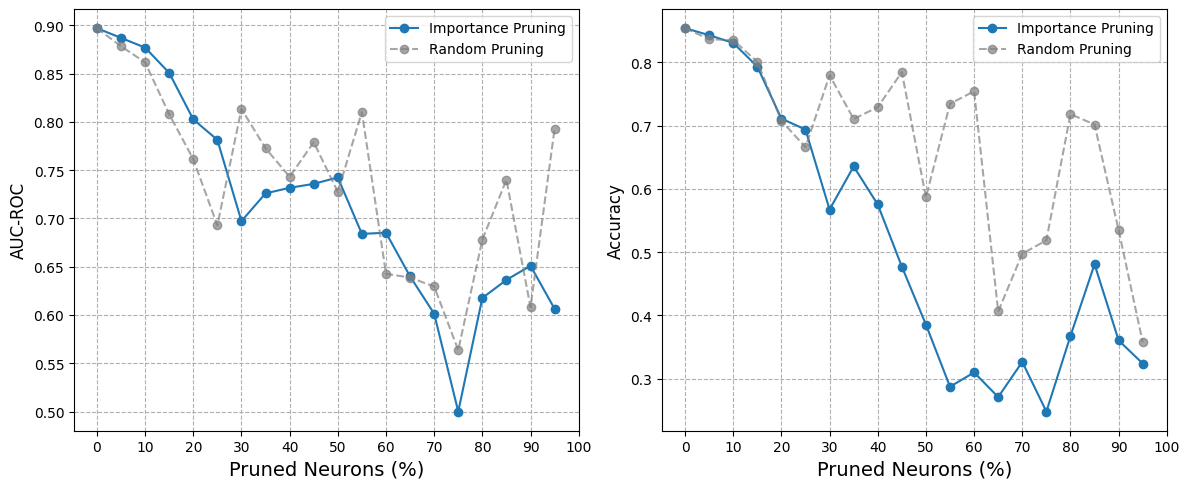

In [21]:
# Baselines: Imporance pruning and random pruning

imp_aucs, imp_accs = [], []
rand_aucs, rand_accs = [], [] 

layer_index = 5 # either 2 or 5

if layer_index == 2:
    layer_size = model.net[0].out_features # Returns 128
elif layer_index == 5:
    layer_size = model.net[3].out_features # Returns 64

for p in prune_percentages:
    print(f"Pruning {p*100:.0f}%...")

    # reset model
    model.load_state_dict(torch.load(model_save_path))
    
    # Importance Pruning
    mask_imp = imp_pruning(layer_index, p, method='tail')
    handle = apply_mask_hook(model, layer_index, mask_imp)
    torch.manual_seed(2025)  # for reproducibility of BN recalibration
    recalibrate_bn(model, trainloader, device='cpu')
    auc, acc = get_metrics(model, X_test_t, y_test)
    imp_aucs.append(auc); imp_accs.append(acc)
    handle.remove()

    # reset model
    model.load_state_dict(torch.load(model_save_path))

    # random pruning
    np.random.seed(SEED_BASE + int(p*100)) # different seed per percentage
    n_prune = int(layer_size * p)
    rand_indices = np.random.choice(layer_size, n_prune, replace=False)
    handle = apply_mask_hook(model, layer_index, rand_indices)

    # apply the random mask and recalibrate the BN
    torch.manual_seed(2025)  # for reproducibility of BN recalibration
    recalibrate_bn(model, trainloader, device='cpu')
    auc, acc = get_metrics(model, X_test_t, y_test)
    rand_aucs.append(auc); rand_accs.append(acc)
    handle.remove()

# Plot 1: AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
ax1.plot(prune_percentages*100, imp_aucs, 'o-', label='Importance Pruning')
ax1.plot(prune_percentages*100, rand_aucs, 'o--', color='gray', alpha=0.7, label='Random Pruning') 
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_xlabel('Pruned Neurons (%)', fontsize=14)
ax1.set_xticks(np.arange(0, 101, 10))
ax1.legend()
ax1.grid(True, linestyle='--')

# Plot 2: Accuracy
ax2.plot(prune_percentages*100, imp_accs, 'o-', label='Importance Pruning')
ax2.plot(prune_percentages*100, rand_accs, 'o--', color='gray', alpha=0.7, label='Random Pruning')
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_xlabel('Pruned Neurons (%)', fontsize=14)
ax2.set_xticks(np.arange(0, 101, 10))
ax2.legend()
ax2.grid(True, linestyle='--')
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(f'figures/synergy/layer_{layer_index}_baseline_pruning.pdf')
plt.show()

Pruning 0%...
Pruning 5%...
Pruning 10%...
Pruning 15%...
Pruning 20%...
Pruning 25%...
Pruning 30%...
Pruning 35%...
Pruning 40%...
Pruning 45%...
Pruning 50%...
Pruning 55%...
Pruning 60%...
Pruning 65%...
Pruning 70%...
Pruning 75%...
Pruning 80%...
Pruning 85%...
Pruning 90%...
Pruning 95%...


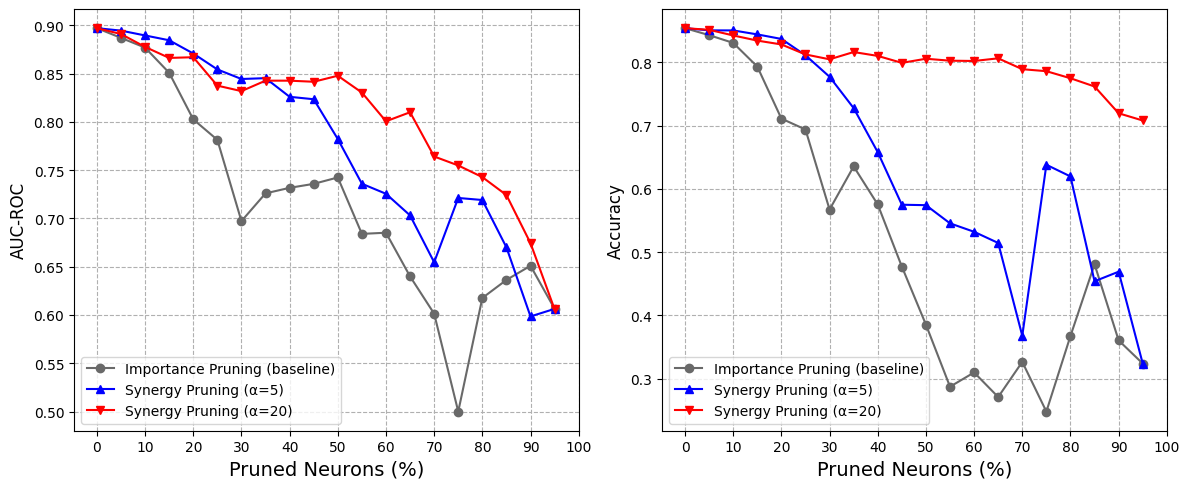

In [23]:
# Synergy Pruning Sweep
imp_aucs, imp_accs = [], []
syn1_aucs, syn1_accs = [], []
syn2_aucs, syn2_accs = [], []

layer_index = 5 # either 2 or 5

if layer_index == 2:
    layer_size = model.net[0].out_features # Returns 128
elif layer_index == 5:
    layer_size = model.net[3].out_features # Returns 64


for p in prune_percentages:
    print(f"Pruning {p*100:.0f}%...")

    # reset model
    model.load_state_dict(torch.load(model_save_path))
    
    # Importance Pruning (Baseline):
    mask_imp = imp_pruning(layer_index, p, method='tail') # select least important neurons
    handle = apply_mask_hook(model, layer_index, mask_imp) # apply the mask
    torch.manual_seed(2025)  # for reproducibility of BN recalibration
    recalibrate_bn(model, trainloader) # recalibrate Batch Norm
    
    auc, acc = get_metrics(model, X_test_t, y_test)
    imp_aucs.append(auc)
    imp_accs.append(acc)
    handle.remove()


    # ==========================================
    # Synergy Pruning (Our Method):

    # alpha = 5.0:

    # reset model
    model.load_state_dict(torch.load(model_save_path))

    mask_syn = synergy_pruning(layer_index, p, alpha=5, method='tail') # select using synergy scores
    handle = apply_mask_hook(model, layer_index, mask_syn)
    torch.manual_seed(2025)  # for reproducibility of BN recalibration
    recalibrate_bn(model, trainloader)
    
    auc, acc = get_metrics(model, X_test_t, y_test)
    syn1_aucs.append(auc)
    syn1_accs.append(acc)
    handle.remove()

    # alpha = 20.0:

    # reset model
    model.load_state_dict(torch.load(model_save_path))

    mask_syn = synergy_pruning(layer_index, p, alpha=20, method='tail') # select using synergy scores
    handle = apply_mask_hook(model, layer_index, mask_syn)
    torch.manual_seed(2025)  # for reproducibility of BN recalibration
    recalibrate_bn(model, trainloader)
    
    auc, acc = get_metrics(model, X_test_t, y_test)
    syn2_aucs.append(auc)
    syn2_accs.append(acc)
    handle.remove()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
x_axis = prune_percentages * 100 # Plot as percentage

# Plot 1: AUC
ax1.plot(x_axis, imp_aucs, 'o-', color='dimgrey', label='Importance Pruning (baseline)')
ax1.plot(x_axis, syn1_aucs, '^-', color='blue', label='Synergy Pruning (α=5)')
ax1.plot(x_axis, syn2_aucs, 'v-', color='red', label='Synergy Pruning (α=20)')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_xlabel('Pruned Neurons (%)', fontsize=14)
ax1.set_xticks(np.arange(0, 101, 10))
ax1.legend()
ax1.grid(True, linestyle='--')

# Plot 2: Accuracy
ax2.plot(x_axis, imp_accs, 'o-', color='dimgrey', label='Importance Pruning (baseline)')
ax2.plot(x_axis, syn1_accs, '^-', color='blue', label='Synergy Pruning (α=5)')
ax2.plot(x_axis, syn2_accs, 'v-', color='red', label='Synergy Pruning (α=20)')
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_xlabel('Pruned Neurons (%)', fontsize=14)
ax2.set_xticks(np.arange(0, 101, 10))
ax2.legend()
ax2.grid(True, linestyle='--')

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(f'figures/synergy/layer_{layer_index}_synergy_pruning.pdf')
plt.show()



# Shap explanations

In [29]:
# reset model
model.load_state_dict(torch.load(model_save_path))
model.eval()

PollockClassifier(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [39]:
# DeepExplainer SHAP
np.random.seed(SEED_BASE)
background = X_train_t[np.random.choice(X_train_t.shape[0], 10000, replace=False)]
shap_explainer = shap.DeepExplainer(model, background)

# You can pass DataFrame, numpy, or tensor — DeepExplainer handles it
rand_indices = np.random.choice(X_test_t.shape[0], 1000, replace=False)
X_test_shap = X_test_t[rand_indices]
print(f"Using {X_test_shap.shape[0]} samples for SHAP, out of {X_test_t.shape[0]} total test samples.")

shap_values = shap_explainer.shap_values(X_test_shap)  
shap_values = shap_values.squeeze()  # shape: (n_samples, n_features)

print("SHAP values shape:", shap_values.shape)

Using 1000 samples for SHAP, out of 108489 total test samples.
SHAP values shape: (1000, 16)


High, Low ratio indices (>0.8): 29, (<0.2): 843
True pok ratio: 0.946


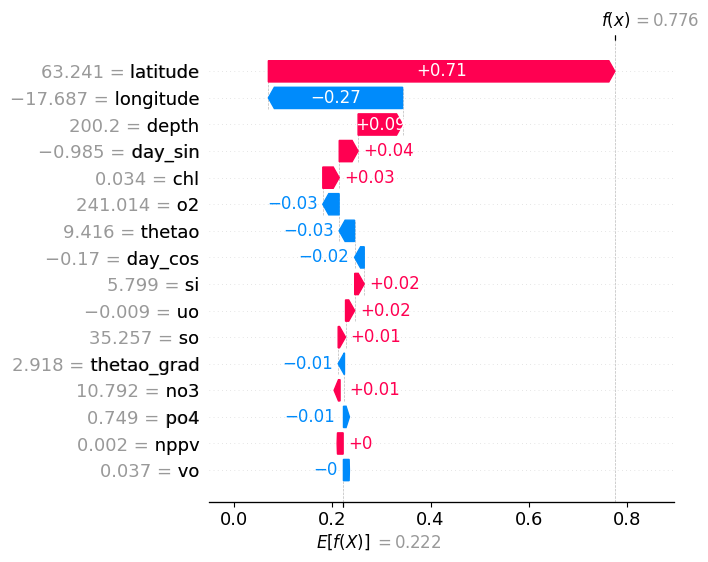

True pok ratio: 0.000


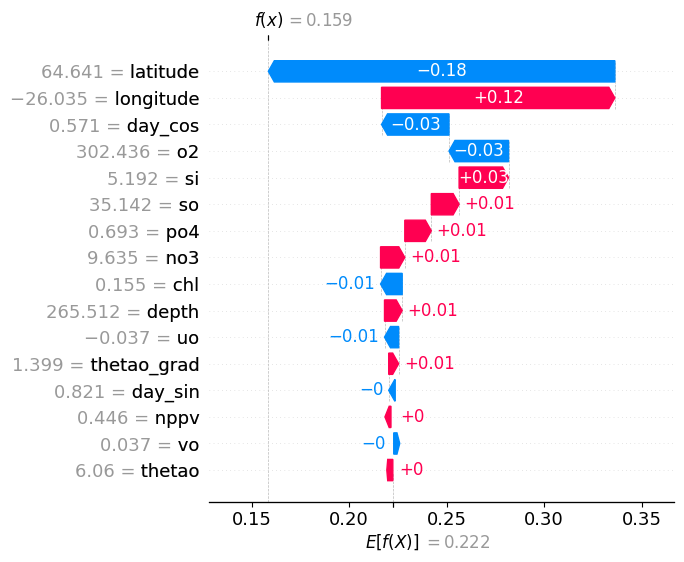

True pok ratio: 1.000


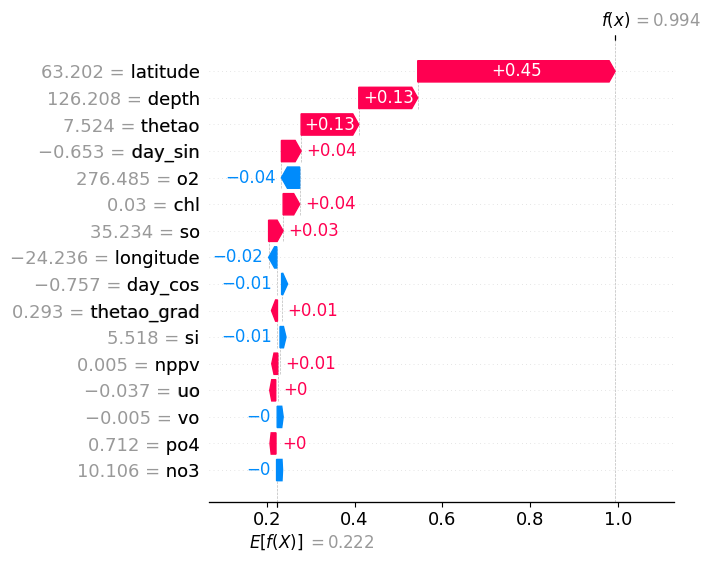

True pok ratio: 0.002


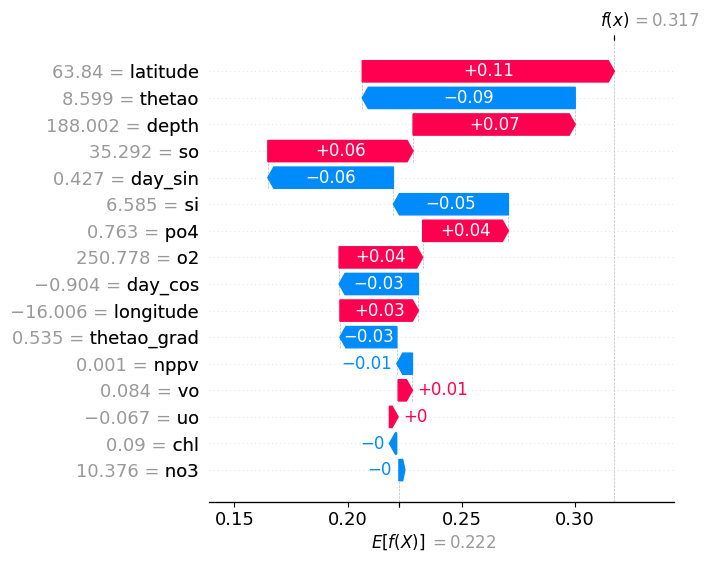

True pok ratio: 1.000


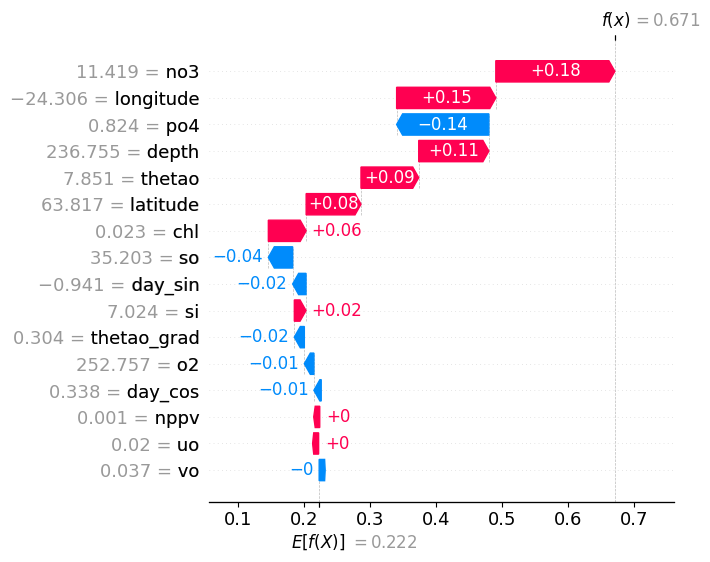

True pok ratio: 0.000


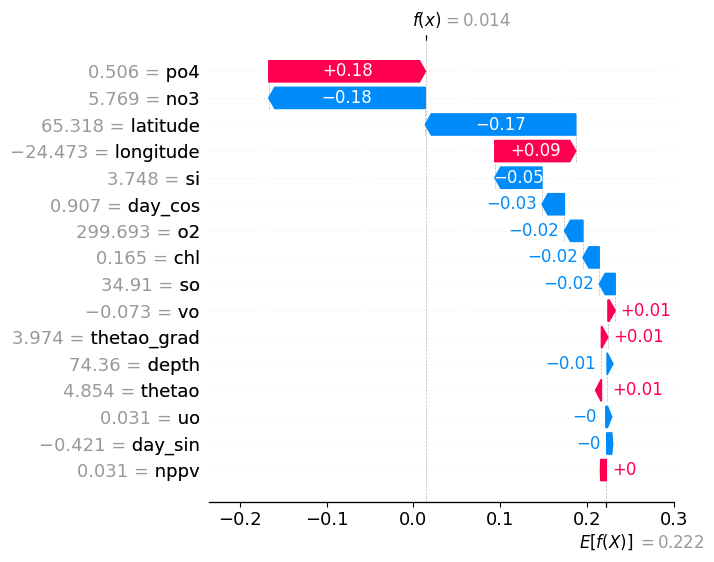

In [40]:
# Generate base values and feature names
base_value = shap_explainer.expected_value.item()
feature_names = X_test.columns.tolist()

# Get true ratios for the SHAP samples
y_shap_ratio = y_test_ratio.iloc[rand_indices]
X_test_shap_unscaled = X_test.iloc[rand_indices]

# Get high and low ratio indices
high_ratio_indices = np.where(y_shap_ratio.values > 0.8)[0]
low_ratio_indices = np.where(y_shap_ratio.values < 0.2)[0]
print(f"High, Low ratio indices (>{0.8}): {len(high_ratio_indices)}, (<{0.2}): {len(low_ratio_indices)}")


def waterfall_one_row(row_idx: int):
    # Takes in row index (of the test subset used for SHAP)
    sv   = shap_values[row_idx]  # shaply values the row
    data = X_test_shap_unscaled.iloc[row_idx].values   # original feature values for that row (unscaled)

    expl = shap.Explanation(
        values      = sv,
        base_values = base_value,
        data        = data,
        feature_names = feature_names
    )

    plt.figure(figsize=(8,6))
    shap.plots.waterfall(expl, max_display=len(feature_names), show=False)

    # print true ratio from y_test_ratio
    print(f"True pok ratio: {y_shap_ratio.iloc[row_idx]:.3f}")


for i in range(SHAP_waterfall_ct):
    np.random.seed(2025 + i)  
    # select random high ratio index
    rand_high_idx = np.random.choice(high_ratio_indices)
    waterfall_one_row(rand_high_idx)

    fig = plt.gcf()
    if SAVE_FIGS:
        fig.set_size_inches(6,6)
        fig.savefig(f'figures/shap/shap_waterfall_high_ratio_{rand_high_idx}_t{y_shap_ratio.iloc[rand_high_idx]:.3f}.pdf', bbox_inches='tight')
    plt.show()

    rand_low_idx = np.random.choice(low_ratio_indices)
    waterfall_one_row(rand_low_idx)
    fig = plt.gcf()
    if SAVE_FIGS:
        fig.set_size_inches(6,6)
        fig.savefig(f'figures/shap/shap_waterfall_low_ratio_{rand_low_idx}_t{y_shap_ratio.iloc[rand_low_idx]:.3f}.pdf', bbox_inches='tight')
    plt.show()


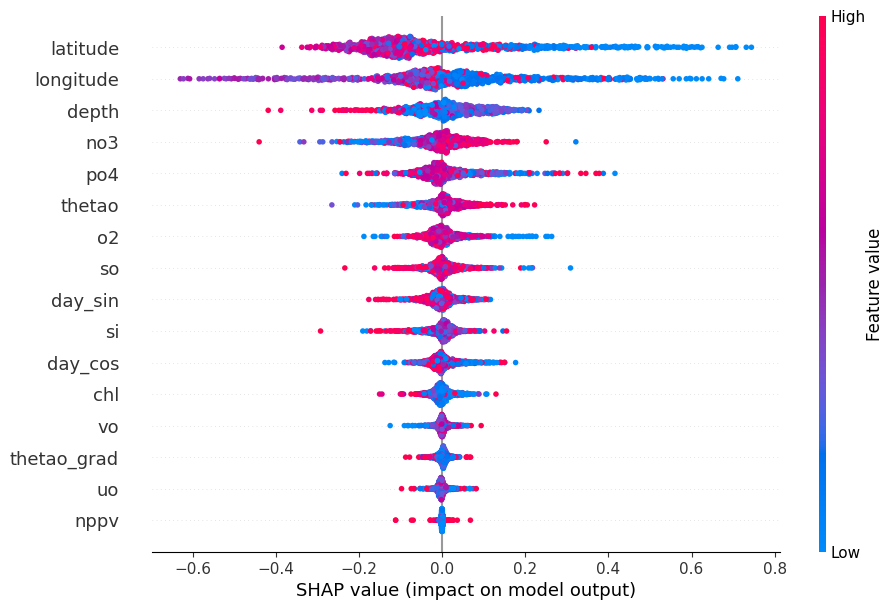

In [41]:
shap.summary_plot(
    shap_values,
    X_test_shap.numpy(),  #might need .cpu(), if running on the cluster
    feature_names=feature_names,
    plot_type="dot",            # types are dot, violin, bar
    max_display=len(feature_names), 
    rng =np.random.default_rng(2025), # seed
    show=False
)
if SAVE_FIGS:
    fig = plt.gcf()
    if SAVE_FIGS:
        fig.set_size_inches(10,6)
        fig.savefig('figures/shap/shap_summary_plot.pdf')
    plt.show()
    

## LIME local explanations

Explaining a False Negative (input idx 1407)
Model prediction: 0.465 (but true label is 1)


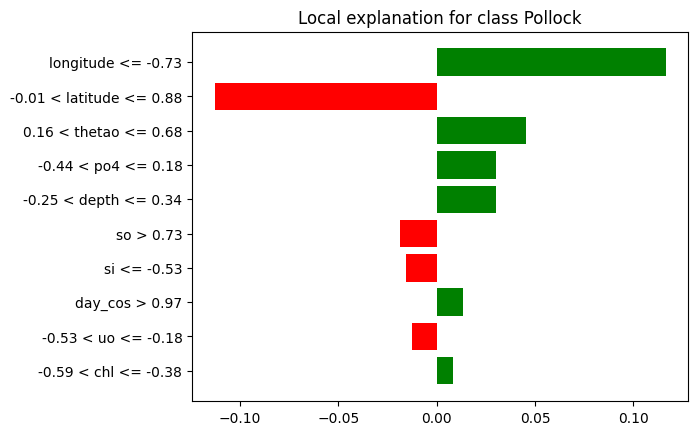

Explaining a False Negative (input idx 2550)
Model prediction: 0.866 (but true label is 0)


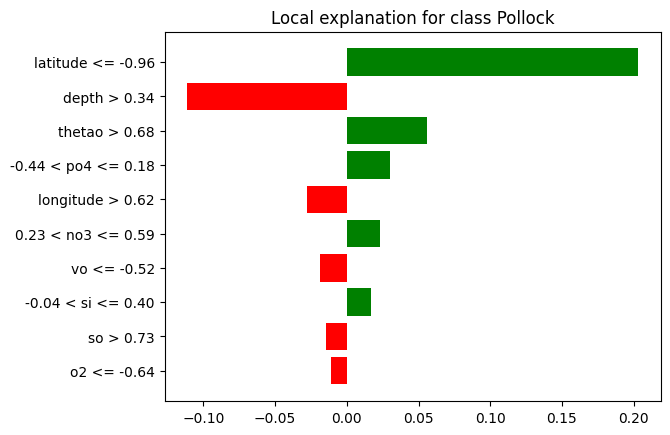

In [ ]:
def lime_predict_proba(numpy_data):
    # Lime prediction function
    """
    Wrapper function to make the PyTorch model compatible with LIME.
    LIME sends data as a (n_samples, n_features) NumPy array.
    """
    model.eval()
    tensor_data = torch.tensor(numpy_data, dtype=torch.float32)
    
    with torch.no_grad():
        preds_p1 = model(tensor_data)
    preds_p0 = 1.0 - preds_p1

    # return stacked predictions [P(class_0), P(class_1)]
    return torch.hstack([preds_p0, preds_p1]).cpu().numpy()

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,  # Use the scaled training data for stats
    feature_names=X_test.columns.tolist(), # Use original feature names
    class_names=['No Pollock', 'Pollock'], # Target class names
    mode='classification'
)

y_pred_flat = y_pred.squeeze() 
y_test_flat = y_test.squeeze()

# Find an index where the model was wrong (predicted 0, but was 1)
fn_indices = np.where((y_test_flat == 1) & (y_pred_flat == 0))[0] # False Negatives
fp_indices = np.where((y_test_flat == 0) & (y_pred_flat == 1))[0] # False Positives


idxs_to_explain = [fn_indices[100], fp_indices[100]]

for i in range(len(idxs_to_explain)):
    idx_to_explain = idxs_to_explain[i]

    print(f"Explaining a False Negative (input idx {idx_to_explain})")
    print(f"Model prediction: {preds[idx_to_explain][0]:.3f} (but true label is {y_test.iloc[idx_to_explain]})")

    # LIME explanation
    exp = lime_explainer.explain_instance(
        data_row=X_test_scaled[idx_to_explain], # scaled data row
        predict_fn=lime_predict_proba,
        num_features=10   # Show top 10 features
    )

    if SAVE_FIGS:
        exp.as_pyplot_figure()
        fig = plt.gcf()
        if i == 0:
            plt.savefig(f'figures/lime/false_negative_p{preds[idx_to_explain][0]:.2f}_t{y_test_ratio.iloc[idx_to_explain]:.2f}.pdf', bbox_inches='tight')
        if i == 1:
            plt.savefig(f'figures/lime/false_positive_p{preds[idx_to_explain][0]:.2f}_t{y_test_ratio.iloc[idx_to_explain]:.2f}.pdf', bbox_inches='tight')
        plt.show()


In [ ]:
np.random.seed(SEED_BASE)
n_samples = 10000

sample_indices = np.random.choice(X_test_scaled.shape[0], n_samples, replace=False)
feature_weights = {name: [] for name in X_test.columns}

print(f"Running LIME on {n_samples} samples. This might take a minute...")

# Run LIME for each sample
for i, idx in enumerate(sample_indices):
    exp = lime_explainer.explain_instance(
        data_row=X_test_scaled[idx],
        predict_fn=lime_predict_proba,
        num_features=len(X_test.columns) 
    )
    
    # Extract weights for Class 1 (Pollock)
    # exp.as_map()[1] returns a list of tuples (feature_index, weight)
    weights_map = dict(exp.as_map()[1])
    
    # Store weights in our dictionary
    for feat_idx, weight in weights_map.items():
        feat_name = X_test.columns[feat_idx]
        feature_weights[feat_name].append(weight)

# tabulate results
results = []
for name, weights in feature_weights.items():
    results.append({
        'Feature': name,
        'Importance (Abs Mean)': np.mean(np.abs(weights)), # Magnitude of impact
        'Effect (Mean)': np.mean(weights),                 # Directional impact (+ or -)
        'Std Dev': np.std(weights)                         # Stability of the feature
    })

# Create DataFrame
df_lime = pd.DataFrame(results)
df_lime_sorted = df_lime.sort_values('Importance (Abs Mean)', ascending=False).reset_index(drop=True)

print("Top 10 Features by LIME Importance (Global Proxy):")
print(df_lime_sorted.head(10))

# latex output
print("\nLaTeX Code:")
print(df_lime_sorted.head(10).to_latex(index=False, float_format="%.4f"))

Running LIME on 10000 samples. This might take a minute...
Top 10 Features by LIME Importance (Global Proxy):
       Feature  Importance (Abs Mean)  Effect (Mean)   Std Dev
0     latitude               0.114834      -0.014882  0.134201
1    longitude               0.063781       0.006961  0.079071
2        depth               0.052077       0.007747  0.060398
3          no3               0.043296      -0.014717  0.049666
4       thetao               0.040896      -0.000018  0.049384
5          po4               0.024275       0.004019  0.029736
6           si               0.019765      -0.001405  0.021775
7           so               0.012193      -0.001078  0.014484
8  thetao_grad               0.009978       0.000230  0.012349
9          chl               0.009858      -0.001115  0.012037

LaTeX Code:
\begin{tabular}{lrrr}
\toprule
Feature & Importance (Abs Mean) & Effect (Mean) & Std Dev \\
\midrule
latitude & 0.1148 & -0.0149 & 0.1342 \\
longitude & 0.0638 & 0.0070 & 0.0791 \\
dep

## Decision Boundary

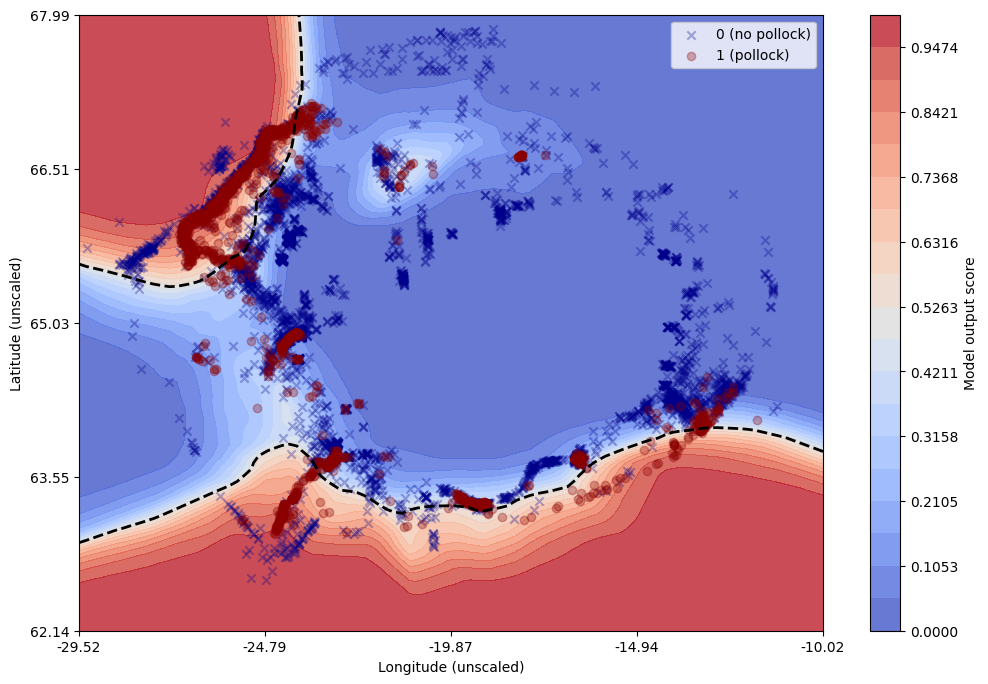

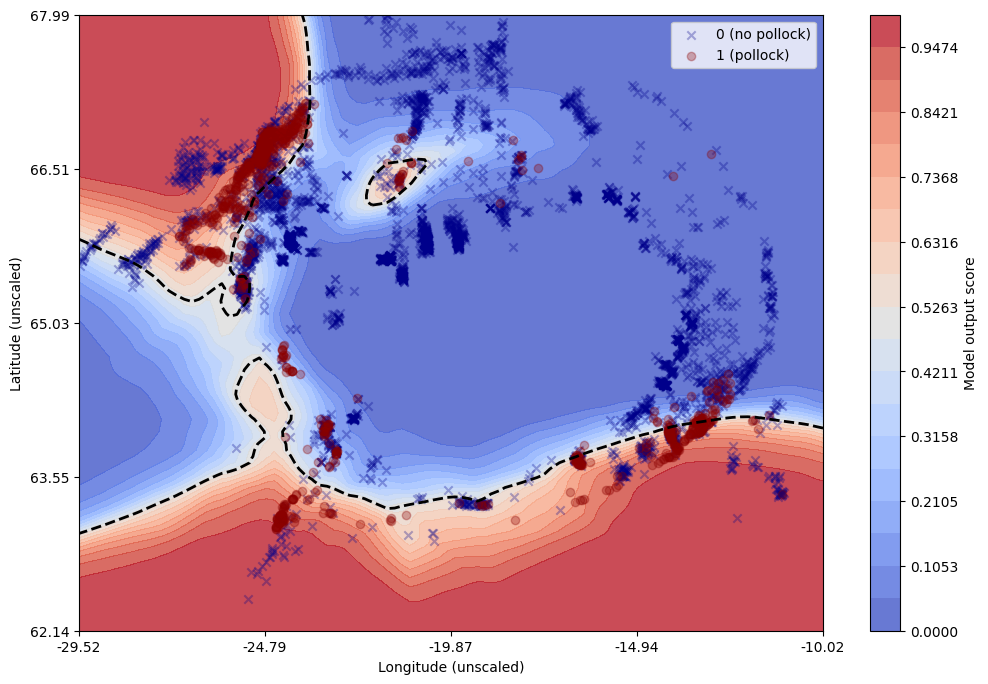

In [47]:
# LIME decision boundary plot for longitude and latitude

feature_names = X_test.columns.tolist()
idx_lon = feature_names.index('longitude')
idx_lat = feature_names.index('latitude')

# fix value for day_cos and day_sin to correspond to mid-year (day 182)
day_of_year = 150

for day_of_year in [150, 200]:
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    idx_day_cos = feature_names.index('day_cos')
    idx_day_sin = feature_names.index('day_sin')

    # grid
    lon_range = np.linspace(X_test_scaled[:, idx_lon].min(), X_test_scaled[:, idx_lon].max(), 100)
    lat_range = np.linspace(X_test_scaled[:, idx_lat].min(), X_test_scaled[:, idx_lat].max(), 100)
    xx, yy = np.meshgrid(lon_range, lat_range)

    # other features set to their mean values
    other_features_mean = X_train_scaled.mean(axis=0)
    grid_data = np.tile(other_features_mean, (xx.ravel().shape[0], 1))

    # set day_cos and day_sin to the fixed values
    grid_data[:, idx_day_cos] = day_cos
    grid_data[:, idx_day_sin] = day_sin

    # 4. Overwrite the lon and lat columns with our grid values
    grid_data[:, idx_lon] = xx.ravel()
    grid_data[:, idx_lat] = yy.ravel()

    # predict on the grid
    model.eval()
    with torch.no_grad():
        grid_tensor = torch.tensor(grid_data, dtype=torch.float32)
        p1_grid = model(grid_tensor).numpy()

    # Reshape predictions to match the grid
    Z = p1_grid.reshape(xx.shape)


    plt.figure(figsize=(12, 8))
    cf = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap='coolwarm', alpha=0.8)
    plt.colorbar(cf, label='Model output score')

    # decision boundary at 0.5
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--', linewidths=2)

    # 7. (Optional) Overlay some actual test data to see how it fits
    test_pos = X_test_scaled[y_test_flat == 1]
    test_neg = X_test_scaled[y_test_flat == 0]

    # filter 10 days before and 10 days after day_of_year
    day_of_years = data_test['date'].dt.dayofyear.reset_index(drop=True)
    day_mask = (day_of_years >= (day_of_year - 10)) & (day_of_years <= (day_of_year + 10))
    test_pos = test_pos[day_mask[y_test_flat == 1]]
    test_neg = test_neg[day_mask[y_test_flat == 0]]

    # Plot a small, random sample to avoid overplotting
    plt.scatter(
        test_neg[:, idx_lon], test_neg[:, idx_lat], 
        alpha=0.3, c='darkblue', marker='x', label='0 (no pollock)'
    )
    plt.scatter(
        test_pos[:, idx_lon], test_pos[:, idx_lat], 
        alpha=0.3, c='darkred', marker='o', label='1 (pollock)'
    )
    # map xticks and yticks back to original lon/lat values
    lon_original = scaler.mean_[idx_lon] + scaler.scale_[idx_lon] * lon_range
    lat_original = scaler.mean_[idx_lat] + scaler.scale_[idx_lat] * lat_range
    plt.xticks(ticks=np.linspace(lon_range.min(), lon_range.max(), 5),
            labels=[f"{val:.2f}" for val in lon_original[np.linspace(0, len(lon_original)-1, 5).astype(int)]])
    plt.yticks(ticks=np.linspace(lat_range.min(), lat_range.max(), 5),
            labels=[f"{val:.2f}" for val in lat_original[np.linspace(0, len(lat_original)-1, 5).astype(int)]])
    plt.xlabel('Longitude (unscaled)')
    plt.ylabel('Latitude (unscaled)')
    plt.legend()
    if SAVE_FIGS:
        plt.savefig(f'figures/decision_boundary_lon_lat_{day_of_year}.pdf', bbox_inches='tight')
    plt.show()